
Why Hidden Markov Models?
===============

Often in biololgy we have complex systems, such as internal apparatus of an organism or an ecosystem, where we have substantial knowledge but not enough to fullly describe or accurately measure the changes within.
We therefore want to reduce the system down to easily understanadable states that encapsulate our percieved understanding of the underlying biololgy. Ideally these understandings can be inferred from easily capturable data sources.

This is where Hidden Markov Models (HMMs) can come in useful. Briefly a HMM is a mathmatical framework that describes a two tiered system, with an observable system (the one we measure) whose changes over time can be inferred to 
represent the changes in a hidden system, one that is often more complex than the observable. We'll go into a bit more depth later about the underling principles later, but a key aspect is knowing when best to apply a HMM, 

Below is a simple checklist you can run through when considering a HMM for your system:

        1. Is your observable data sequential, i.e. a time series dataset or a linear structure such as protein sequences

        2. Can the underlying system (hidden states) be reasonably represented as distinct, descrete states

        3. Is it reasonable to think these hidden states are associated with our observable data

        4. Can I interpret and test the outputs to validate the model

        5. Can the system be modelled under the Markovian assumption (don't worry we'll get to that, but it's very simple)


We'll use this as a point to introduce the system we'll be modelling throughout this tutorial, sleep in *Drosophila Melanogaster*. Lets go through some background to the topic to help us answer the checklist above. Sleep has been studied in fruit flies since 2000 after sleep-like states were observed when the flies were immobile, causing a boom in studies looking to utilise all the genetic tools in fruit flies to gain a better understanding to the general theory of sleep. The flies can be housed in tubes with their activity measured for many days with external inputs to change their environment. For a long time sleep in flies was mostly considered a uniform, monostate event, something at odd with our knowledge of mammalian sleep which has several phases. However, the gold standard for determing sleep states, EEGs, cannot be used with fruit flies sure to the small size of their brains. But with wew studies using alternative methods researched have shown changes in the whole brain activity throughout sleep bouts that would indicate changing sleep states. The methods are very invasive and difficult to setup, leading to the question, can we predict these internal changes from more easily accesible data.

THe data we'll be working with is movement data tracked by an ethoscope, a device that can track ~20 flies at once through machine vision. You can read more about them in this [publication](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2003026).

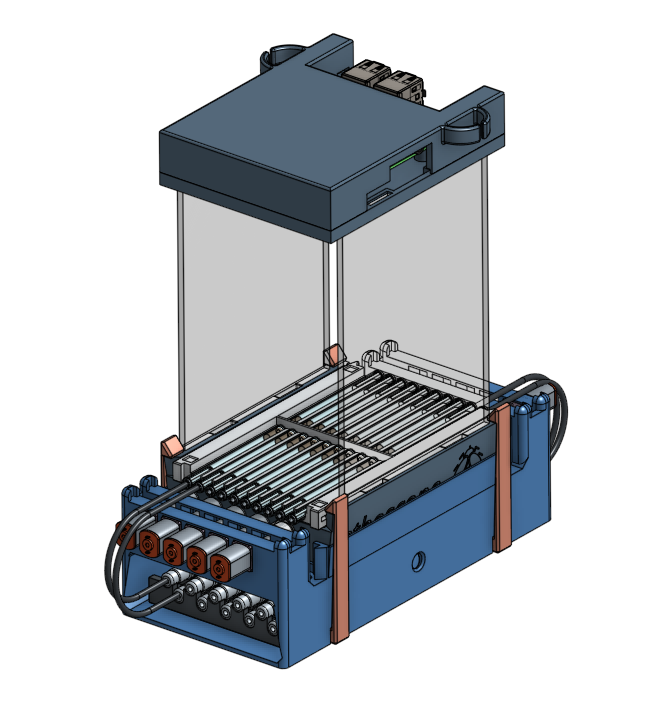
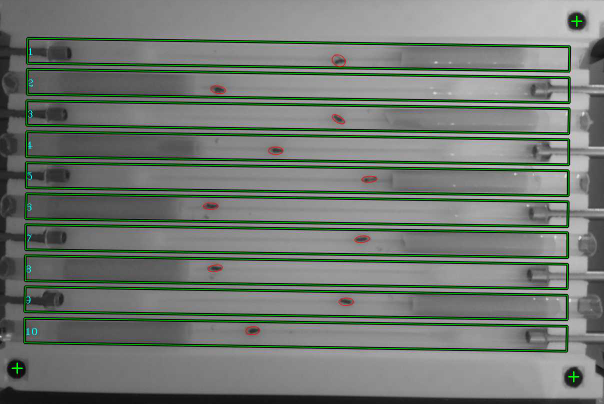

Above in the rihgthand picture you can see the flies encirecled in red. The Ethoscope will track the flies, recording their position on a micro scale, these x,y coordinates will be recorded in a database with a timestamp to give us a multivariable time series. We'll look at and get to grip with this dataset in the next notebook. But first lets apply the system and data to the above check list.

We'll apply this to the checklist:

        1. Is your observable data sequential, i.e. a time series dataset or a linear structure such as protein sequences
**Yes - the data is a time series tracking each individual fly across the day**

        2. Can the underlying system (hidden states) be reasonably represented as distinct, descrete states
**Yes - Our understanding of mammalian (and birds and reptiles) is of distinct sleep states, so we can apply that to flies**

        3. Is it reasonable to think these hidden states are associated with our observable data
**Quite likely - most animals are immobile when sleeping with pre-sleep rituals that are driven by an internal change**

        4. Can I interpret and test the outputs to validate the model
**Yes - Sleep is often measured by the change in arousability, so we can test the predicted states against this**

        5. Can the system be modelled under the Markovian assumption (don't worry we'll get to that, but it's very simple)
**We'll answer this one below**

Now its passed all the checks, lets have a deeper look at markov models to understand how to use them.

What are Hidden Markov Models
=====

HMMs are probabilistic models that work as a sequence of labelling problems, where the labelling problem is the how a chain of observable events are determined by an internal factors that can't be directly observed.

Both parts of a HMM, the hidden process and the observable process, are assumed to be a [stochastic processes](https://en.wikipedia.org/wiki/Stochastic_process), by which they are series of events that have an underlying randomness within a probabilstic space. Simply the data will have elements of randomness but within a known confine of outputs. For example daily temperature can be predicted and modelled but underlying randomness in global weather will never make the recorded data fit 1-to-1 with a model.

The hidden process is a markov chain, the basis for HMMs. A Markov chain (or Markovian assumption) follows the assumption that probability of the next state in the sequence is only determined by the one you're in currently, so it's a memory-less system, none of the previous history matters where it going to next, with a fixed matrix of probabilities that will infer what the next state will come. 

For those of you who like mathmatical equations see below for the markov chain rule:

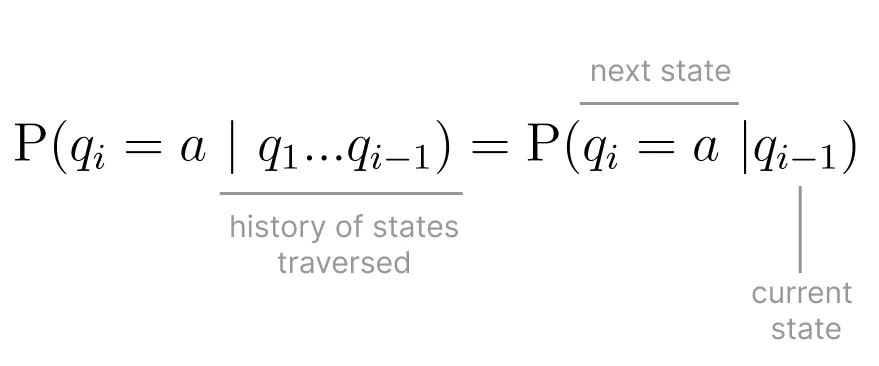

Back to our checklist briedly now we know what markov chains are:

        5. Can the system be modelled under the Markovian assumption (don't worry we'll get to that, but it's very simple)
**Most modelling is reductive, we're taking a system with thousands of interacting parts and looking at their probabilistic output. It's therefore not a definitive reflection of reality and our assumptions are the same. Applying this philosophy to the Markovian assumption we do know sleep stage transitions in mammals is determined by the previous as it changes from REM to NREM. But we also recognise it's not a memory-less process, the amount of sleep you've had previously may affect the time periods in each stages. So we'll still plow on with the HMM, but we will understand its limitations and use that to help us interpret the output within context**

Likewise the observable (emission in the literature) process is also assumed to be a markov chain, it is assumed that each observed state is only dependant on the state that produced it, independant of any of the previous states prior, with each hidden state having a probability matrix that represents the liklihood it will emit any given state. 

Overall you can now see the a Hidden Markov Model is quite simple, with the basis being the liklihood of states transitioning into one another and the liklihood they infer an observable state.

To sum up the parts you have:

        1. The observable process
                a. A sequence of observable states
                b. A probability emission matrix (what you train)
        
        2. The hidden process
                a. A state architecture desgined by you
                b. A probability transition matrix (what you train)
        
We'll take these parts and generate representations for our example.

Breaking down the parts
=====

For this section we'll create a scenario to help explain the components.

Lets assume students at Imperial are known to have three different state of moods: Tired, Motivated, Happy. We ask a student to record their mood every day for a year.

We'll generate this data and look at it as a markov chain. For this we'll be using Numpy a python package for creating and manipulating data array. You may already be familiar with it, if not don't fear everythign that is shown will be explained. If curious you can head to their website for more information -> [here](https://numpy.org/doc/stable/user/quickstart.html)

In [55]:
# we'll import numpy to the notebook, it is comonaly imported as np to make it shorter
import numpy as np

# length of a year in days
l = 365

# We'll want to represent our moods as numbers, so first we'll create a dictionary that show us what mood equals what number
mood_dict = {'Tired' : 0, 'Motivated' : 1, 'Happy' : 2}

# random.randint creates an array of a given length that contains a random sequence of integers within our contraints 0 and 3 (where 3 is one above the maximum)
# So for ours its only numbers 0, 1, and 2 with a length of 365
# Everytime this cell is run it'll generate a new array
mood_array = np.random.randint(low = 0, high  = len(mood_dict), size = l)

# We can now see our data
mood_array

array([2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 0, 0, 2, 1, 0, 2, 2, 1, 0, 2, 0, 0,
       0, 1, 2, 1, 2, 0, 1, 0, 0, 2, 2, 1, 1, 0, 1, 0, 2, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 0, 0,
       0, 2, 0, 1, 2, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 0, 2, 0, 0,
       2, 0, 2, 1, 2, 0, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0, 0, 0,
       2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 2, 1, 2, 2, 1, 2,
       2, 2, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 2, 0, 2, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 0,
       2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1,
       1, 1, 0, 2, 0, 0, 2, 2, 1, 2, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 2, 0, 1, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 0, 2, 2, 0,
       0, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 1, 1, 1, 2,
       0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2,
       0, 0, 1, 2, 0, 2, 2, 2, 2, 0, 1, 1, 1, 2, 1,

Now we have some data we can calcutate the transition matrix for this data. The transition matrix is the liklihood one state will transition into another, it is represented as a matrix whose shape is the number of states both across and down. So in our case the rows will be of length 3 and there will be 3 of them. Each row must sum to 1, as it encapsulates all posibilities. See the example below:

$ Tmatrix = \left[\begin{array}{ccc}
0.1 & 0.5 & 0.4\\
0.6 & 0.2 & 0.2\\
0.3 & 0.4 & 0.3
\end{array}\right]$

We can calculate the transition matrix by counting all the occurances of each transition.

In [56]:
# Don't worry too much about this function
# For now it takes the array and goes through it point by point

def transition_matrix(transitions):
    
    n = 1 + max(transitions) # the number of states, i.e 3

    M = np.zeros((n,n)) # Create an empty matrix of shape 3 x 3

    # Here it loops through the original array and one shifted to the right 1 place
    # This is give you on every loop a state and its next neighbour, for every occurance the matrix is updated with a count
    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    # Now we divide by the total to get the probabilities
    M = M/M.sum(axis=1, keepdims=True)
    return M

In [59]:
# Call the function and see the output
t_matrix = transition_matrix(mood_array)

t_matrix

array([[0.36585366, 0.37398374, 0.2601626 ],
       [0.30714286, 0.40714286, 0.28571429],
       [0.34653465, 0.36633663, 0.28712871]])

When this notebook was first run the transition matrix came to (to 2 decimal places):


$ MoodMatrix = \left[\begin{array}{ccc}
0.37 & 0.37 & 0.26\\
0.30 & 0.41 & 0.29\\
0.34 & 0.37 & 0.29
\end{array}\right]$

Which can be better read as:

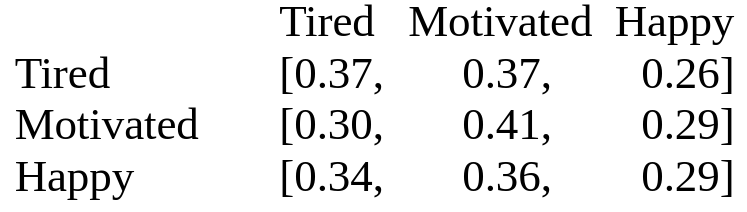

Or visually as:

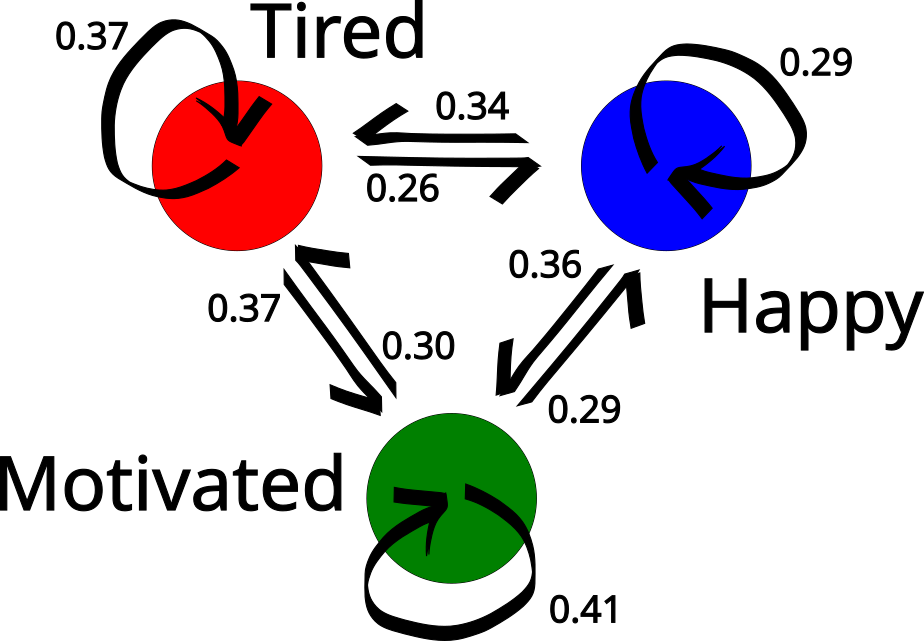

With this transition matrix we could then use it to predict the liklihood of the person being happy 5 days after they were tired, or the liklihood of 3 days of motivation in a row. However, we're not interested in the markov chain but a Hidden Markov Model.

Extra task: - calculate what state is most likely 3 days after being Tired
            - calculate the chance of 5 days of happiness in a row

So we'll take this markov chain and change it into the hidden layer, we infact have no inf

In [69]:
# code to calvulate 3 days after tired
start_m = np.array([1,0,0])
for i in range(3):
    start_m = start_m.dot(t_matrix)

start_m

array([0.33793928, 0.38461373, 0.27744699])

# **TO DO**

## Show the transition from the markov model to the hidden markov model. Observable == working, not working

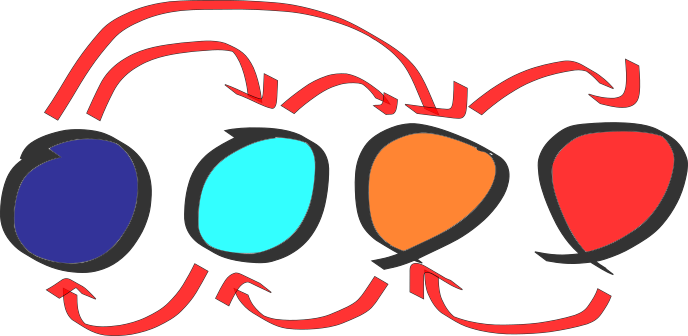

# **TO DO**

## Steps to a HMM. 1. adding the the hidden layer to the markov chain 2. how training works (the forward algorithm), 2. how decoding works (viterbi algorithm)
### Outcome - An overview of the maths behind it, but now in depth. But the student should know what is happening in each step and how they fit together

# **Extra Tasks**

##